# FRGC Clustering with RetinaFace + ArcFace

## 0. Setup

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import cv2
from insightface.app import FaceAnalysis
from tqdm import tqdm
import pandas as pd
from joblib import Parallel, delayed

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1' #use both GPU

## 1. Load FRGC dataset

In [4]:
FRGC_root = '/d1/jferna27/FRGC-nd1/all'
csv_path = '../frgc cluster/frgc_face_embeddings.csv'

if os.path.exists(csv_path): # CSV found, load from it
    print(f"Found {csv_path}, person ids loaded from csv")
    df = pd.read_csv(csv_path) #df.columns: 512d,image_file,, person_id
    image_files = df['image_file'].tolist()
    print(f"Total images: {len(image_files)}")
    person_ids = df['person_id'].tolist()  #person_id column from CSV
    unique_persons = sorted(list(set(person_ids)))
    print(f"Identities: {len(unique_persons)}")
    csv_pids = set(df['person_id'].tolist())

else: # CSV not found, use FRGC_root directory scan
    image_files = [f for f in os.listdir(FRGC_root) if f.endswith('.JPG') or f.endswith('.jpg')]
    print(f"Total images: {len(image_files)}")
    person_ids = [img[:5] for img in image_files] #person id (1st 5 characters)
    unique_persons = sorted(list(set(person_ids)))
    print(f"Identities: {len(unique_persons)}")

Found ../frgc cluster/frgc_face_embeddings.csv, person ids loaded from csv
Total images: 39327
Identities: 568


## 2. Initialize Face Detection + Embeddings

## 3. Extract embeddings (parallel processing on both GPUs)

In [5]:
if os.path.exists(csv_path): #use csv if exists
    print("Found frgc_face_embeddings.csv")
    df = pd.read_csv(csv_path)
    drop_cols = ['image_file', 'person_id']
    emb_cols = [c for c in df.columns if c not in drop_cols]
    embeddings = df[emb_cols].values
    valid_person_ids = df['person_id'].tolist()  # Use person_id directly
    valid_image_files = df['image_file'].tolist()

else: #csv does not exist, process images to extract embeddings
    print(f"Processing with GPU 0 and 1")
    def process_batch_worker(gpu_id, batch_data):
        app = FaceAnalysis(name="buffalo_l")
        app.prepare(ctx_id=gpu_id, det_size=(160, 160))
        embs, pids, files = [], [], []
        for img_file, pid in tqdm(batch_data, desc=f"GPU {gpu_id}"):
            img = cv2.imread(os.path.join(FRGC_root, img_file))
            if img is not None:
                faces = app.get(img)
                if len(faces) > 0:
                    embs.append(faces[0].embedding)
                    pids.append(pid)
                    files.append(img_file)
        return {'embs': embs, 'pids': pids, 'files': files}
    
    person_ids_list = [img[:5] for img in image_files]
    mid = len(image_files) // 2
    results = Parallel(n_jobs=2, backend='loky')(
        delayed(process_batch_worker)(gpu_id, list(zip(image_files[start:end], person_ids_list[start:end])))
        for gpu_id, (start, end) in [(0, (0, mid)), (1, (mid, len(image_files)))]
    )
    embeddings = np.vstack([np.array(r['embs']) for r in results])
    valid_person_ids = sum([r['pids'] for r in results], [])
    valid_image_files = sum([r['files'] for r in results], [])

print(f"Embeddings: {embeddings.shape}")
print(f"Valid images: {len(valid_image_files)}")
print(f"Unique person_ids: {len(set(valid_person_ids))}")

Found frgc_face_embeddings.csv
Embeddings: (39327, 512)
Valid images: 39327
Unique person_ids: 568


In [6]:
if os.path.exists(csv_path):
    print(f"{csv_path} already exists.")
else: #save csv
    embeddings_df = pd.DataFrame(embeddings)
    embeddings_df['person_id'] = valid_person_ids
    embeddings_df['image_file'] = valid_image_files
    embeddings_df.to_csv(csv_path, index=False)
    print(f"Embeddings and person_ids saved to {csv_path}")

../frgc cluster/frgc_face_embeddings.csv already exists.


## 4. Cluster by identity

In [ ]:
labels_arr = np.array(valid_person_ids)  # array of person_ids
unique_ids = np.unique(labels_arr)  # unique person ids
counts = {pid: int((labels_arr == pid).sum()) for pid in unique_ids}
min_imgs = 100
keep_ids = [pid for pid, c in counts.items() if c >= min_imgs]
print(f"Identities with >= {min_imgs} images: {len(keep_ids)}/{len(unique_ids)}")

mask = np.isin(labels_arr, keep_ids)
labels_arr = labels_arr[mask]
embeddings = embeddings[mask]
valid_person_ids = labels_arr.tolist()
unique_ids = np.unique(labels_arr)

identity_indices = {pid: np.where(labels_arr == pid)[0] for pid in unique_ids}  # map person_id to indices
identity_clusters = {pid: embeddings[idxs] for pid, idxs in identity_indices.items()}  # map person_id to embeddings

Identities with >= 100 images: 142/142


In [10]:
cluster_stats = {}
for pid, cluster in identity_clusters.items():
    centroid = cluster.mean(axis=0)
    distances = np.linalg.norm(cluster - centroid, axis=1)
    cluster_stats[pid] = {
        "centroid": centroid,
        "radius": float(distances.max()),
        "dispersion": float(distances.std()),
        "num_images": int(len(cluster))
    }

In [11]:
print(cluster_stats)

{2463: {'centroid': array([ 1.36079760e+00, -5.53617906e-01,  8.19623687e-01, -5.97872120e-01,
        7.04318322e-01,  6.38033939e-01, -2.29981774e-02,  7.24419654e-01,
        1.26011928e+00,  6.89536185e-01, -4.32604623e-01,  4.37730998e-01,
       -9.29212914e-01, -1.88015310e-01,  2.98649382e-01,  1.77353284e-02,
        2.62412907e-02,  1.93048870e-02, -2.61366673e-01,  6.01749572e-01,
       -4.30036073e-02, -1.51317886e+00,  1.53724335e+00, -1.48630439e-01,
        2.90227277e-01, -4.13044099e-01,  9.34751462e-01,  1.05606430e+00,
       -1.50293793e+00, -1.18616631e+00, -4.88096725e-01,  5.07334496e-02,
        1.39240670e-01,  6.09696958e-01, -9.55037789e-02, -9.25457512e-01,
       -1.76883396e+00, -1.88725922e-01,  5.79524863e-01,  1.51770896e+00,
       -1.15441726e+00,  1.01814885e+00,  7.52622860e-03, -8.39216265e-01,
        2.34194277e-01,  1.56428035e-01, -1.26693369e-01,  7.43600427e-01,
        6.68994034e-01, -1.41671365e+00, -6.81525315e-01, -3.96701126e-01,
     

## 5. Intrinsic dimensionality

In [12]:
intrinsic_dim = {}
for pid, cluster in identity_clusters.items():
    if cluster.shape[0] < 2:
        continue
    pca = PCA(n_components=min(cluster.shape[0], cluster.shape[1]))
    pca.fit(cluster)
    intrinsic_dim[pid] = int(np.sum(pca.explained_variance_ratio_ > 0.01))

- pca.explanined_variance_ratio_: vector size min(n,D) contains the fraction of variance explained for each principal component.
- .>0.01: PC explains more than 1%
- sum the ones that are >0.01, and those are the intrinsic dimension

In [13]:
#intrinsic dimensions by identity
for identity, dim in intrinsic_dim.items():
    print(f"Identity: {identity}, Intrinsic Dimension: {dim}")

Identity: 2463, Intrinsic Dimension: 19
Identity: 4201, Intrinsic Dimension: 22
Identity: 4202, Intrinsic Dimension: 19
Identity: 4203, Intrinsic Dimension: 18
Identity: 4213, Intrinsic Dimension: 23
Identity: 4217, Intrinsic Dimension: 23
Identity: 4221, Intrinsic Dimension: 19
Identity: 4222, Intrinsic Dimension: 19
Identity: 4225, Intrinsic Dimension: 20
Identity: 4233, Intrinsic Dimension: 20
Identity: 4239, Intrinsic Dimension: 19
Identity: 4261, Intrinsic Dimension: 20
Identity: 4265, Intrinsic Dimension: 20
Identity: 4273, Intrinsic Dimension: 19
Identity: 4279, Intrinsic Dimension: 19
Identity: 4286, Intrinsic Dimension: 19
Identity: 4288, Intrinsic Dimension: 21
Identity: 4297, Intrinsic Dimension: 20
Identity: 4300, Intrinsic Dimension: 21
Identity: 4301, Intrinsic Dimension: 18
Identity: 4309, Intrinsic Dimension: 19
Identity: 4311, Intrinsic Dimension: 20
Identity: 4312, Intrinsic Dimension: 24
Identity: 4319, Intrinsic Dimension: 21
Identity: 4320, Intrinsic Dimension: 20


In [15]:
identities = list(intrinsic_dim.keys())
dimensions = list(intrinsic_dim.values())
n = len(identities)
bar_width = 0.8
width_per_bar = 0.10
fig_width = max(18, n * width_per_bar) 
fig_height = 8

fig, ax = plt.subplots(figsize=(fig_width, fig_height))
ax.bar(range(n), dimensions, color='blue', alpha=0.8, width=bar_width)
ax.set_xticks(range(n))
ax.set_xticklabels(identities, rotation=90, fontsize=6)
ax.set_xlabel('Person ID', fontsize=12)
ax.set_ylabel('Intrinsic Dimension', fontsize=12)
ax.set_title('Intrinsic Dimension by Identity (FRGC Dataset) — all labels', fontsize=14)
ax.grid(True, alpha=0.1, axis='y')
plt.tight_layout()
fig.savefig('intrinsic_all_labels_filters.png', dpi=150, bbox_inches='tight')
plt.close(fig)

from IPython.display import HTML, display #html container with scroll so labels dont overlap
display(HTML(f"<div style='width:100%; overflow:auto; border:1px solid #ddd; padding:6px'><img src=\"{'intrinsic_all_labels.png'}\" style=\"height: auto;\"></div>"))

## 6. Visualization Clusters

Number of clusters: 142


Number of clusters: 142


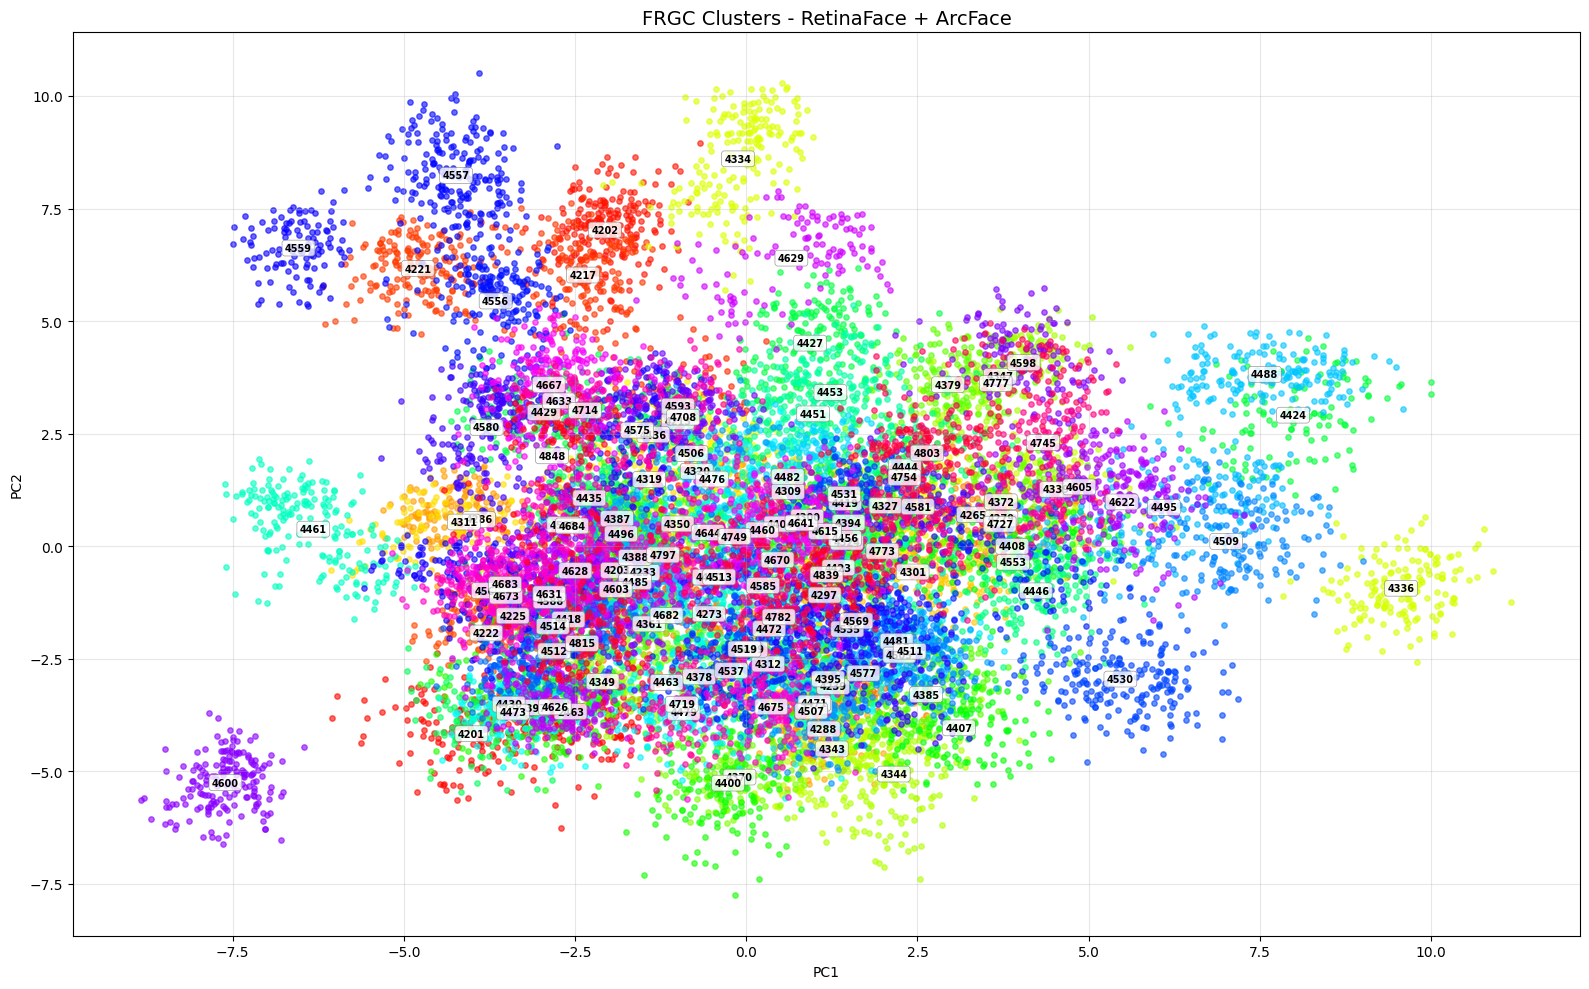

In [16]:
pca_2d = PCA(n_components=2)
emb_2d = pca_2d.fit_transform(embeddings)
centroids_2d = pca_2d.transform(np.array([cluster_stats[name]['centroid'] for name in cluster_stats.keys()]))

# use person id strings as labels
labels_arr = np.array(valid_person_ids)
unique_ids = np.unique(labels_arr)
num_clusters = len(unique_ids)
print(f"Number of clusters: {num_clusters}")
colors = plt.cm.hsv(np.linspace(0, 1, num_clusters))

plt.figure(figsize=(16, 10))
for idx, pid in enumerate(unique_ids):
    cluster_points = emb_2d[labels_arr==pid]
    if cluster_points.size == 0:
        continue
    plt.scatter(cluster_points[:,0], cluster_points[:,1], s=15, alpha=0.6, color=colors[idx])
    centroid_2d = cluster_points.mean(axis=0)  # centroid in 2d

    person_id = pid
    plt.text(centroid_2d[0], centroid_2d[1], person_id, fontsize=7, ha='center', va='center',bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='gray', linewidth=0.5), fontweight='bold')

plt.title("FRGC Clusters - RetinaFace + ArcFace", fontsize=14)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

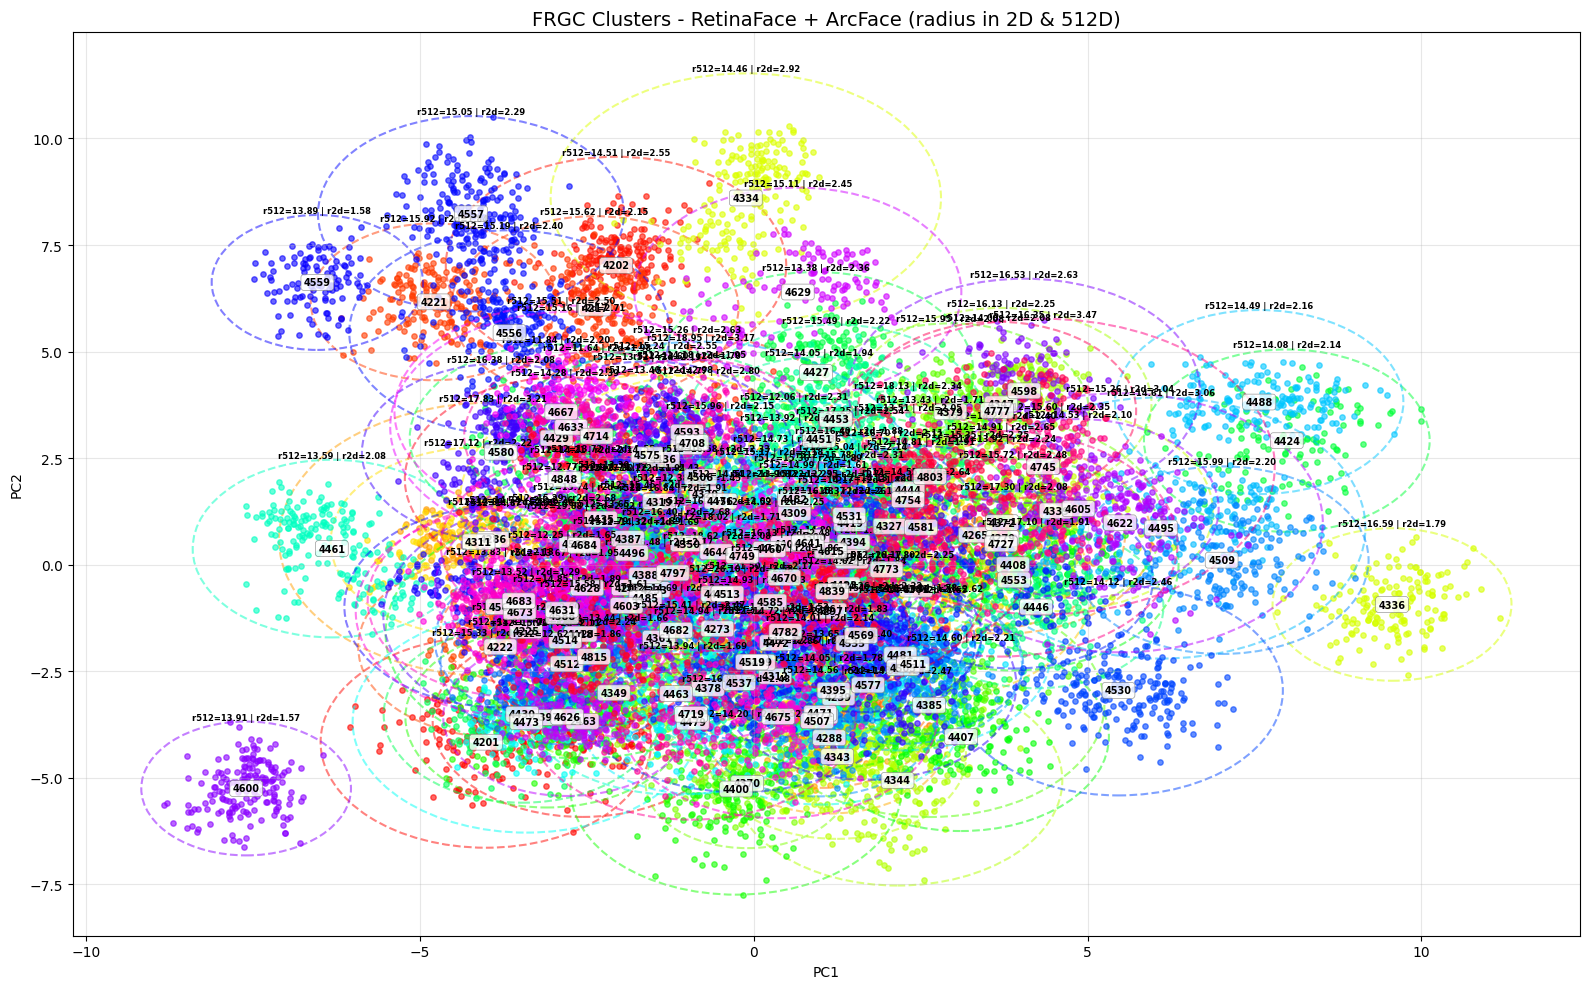

In [17]:
# same figure but with radius circles (using person_id strings)
plt.figure(figsize=(16, 10))
labels_arr = np.array(valid_person_ids)
unique_ids = np.unique(labels_arr)
colors = plt.cm.hsv(np.linspace(0, 1, len(unique_ids)))
for idx, pid in enumerate(unique_ids):
    cluster_points = emb_2d[labels_arr==pid]
    if cluster_points.size == 0:
        continue
    plt.scatter(cluster_points[:,0], cluster_points[:,1], s=15, alpha=0.6, color=colors[idx])
    person_id = pid
    centroid_2d = cluster_points.mean(axis=0)  # centroid cluster in 2D space

    distances_2d = np.linalg.norm(cluster_points - centroid_2d, axis=1)  # max radius in 2D
    radius_2d = distances_2d.max()
    radius_512d = cluster_stats[person_id]['radius']  # radius in original 512D space

    circle = plt.Circle(centroid_2d, radius_2d, color=colors[idx], fill=False, linewidth=1.5, linestyle='--', alpha=0.5)
    plt.gca().add_patch(circle)
    plt.text(centroid_2d[0], centroid_2d[1], person_id, fontsize=7, ha='center', va='center',bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='gray', linewidth=0.5),fontweight='bold')
    plt.text(centroid_2d[0], centroid_2d[1] + radius_2d, f'r512={radius_512d:.2f} | r2d={radius_2d:.2f}', fontsize=6, ha='center', va='bottom', color="black", fontweight='bold')

plt.title("FRGC Clusters - RetinaFace + ArcFace (radius in 2D & 512D)", fontsize=14)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [18]:
# top 2 persons with most images and 1 with the least images
sorted_by_images = sorted(cluster_stats.items(), key=lambda kv: kv[1]['num_images'], reverse=True)
selected_people = sorted_by_images[:2] + [sorted_by_images[-1]] if len(sorted_by_images) >= 3 else sorted_by_images
person_ids = [pid for pid, _ in selected_people]
# use person_id strings directly
person1_id, person2_id, person3_id = person_ids[0], person_ids[1], person_ids[2]

In [19]:
labels_arr = np.array(valid_person_ids)
person1_index = np.where(labels_arr == person1_id)[0] #index person
person2_index = np.where(labels_arr == person2_id)[0]
person3_index = np.where(labels_arr == person3_id)[0]

print(f"Person {person_ids[0]}: {len(person1_index) if person1_index is not None else 0} images in dataset")
print(f"Person {person_ids[1]}: {len(person2_index) if person2_index is not None else 0} images in dataset")
print(f"Person {person_ids[2]}: {len(person3_index) if person3_index is not None else 0} images in dataset")

Person 4202: 220 images in dataset
Person 2463: 218 images in dataset
Person 4361: 100 images in dataset


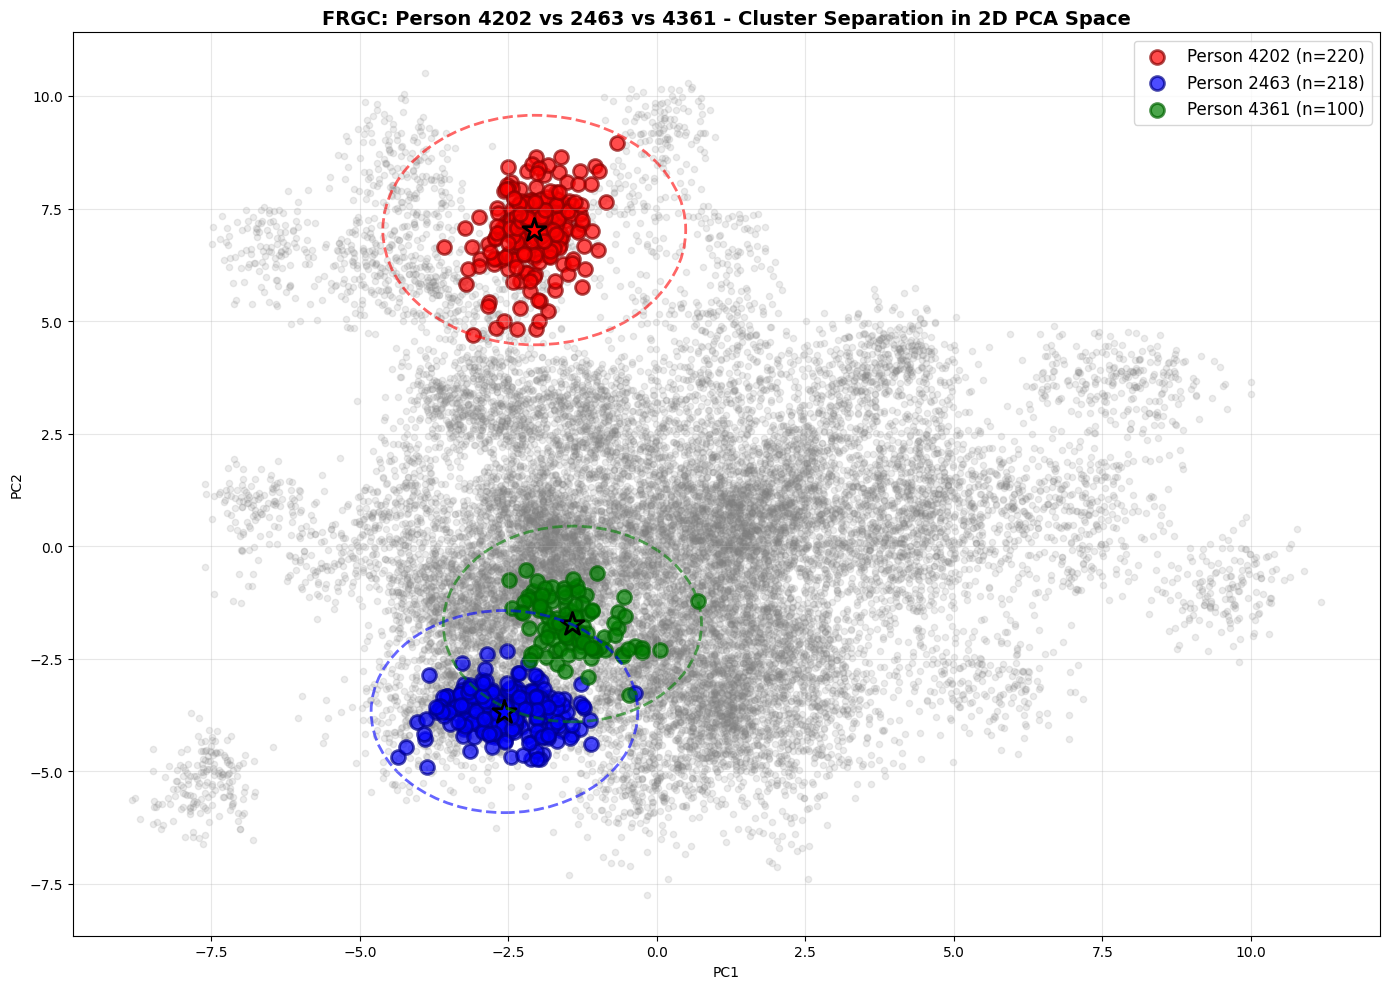

In [20]:
# 2d projections (using person_id strings)
labels_arr = np.array(valid_person_ids)
person1_2d = emb_2d[labels_arr == person1_id]
person2_2d = emb_2d[labels_arr == person2_id]
person3_2d = emb_2d[labels_arr == person3_id]

#clusters
plt.figure(figsize=(14, 10))
# all other clusters in gray
for pid in np.unique(labels_arr):
    if pid not in [person1_id, person2_id, person3_id]:
        cluster_points = emb_2d[labels_arr == pid]
        if cluster_points.size > 0:
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=20, alpha=0.15, color='gray', label=None)
#three persons
plt.scatter(person1_2d[:, 0], person1_2d[:, 1], s=100, alpha=0.7, color='red', edgecolors='darkred', linewidth=2, 
            label=f'Person {person_ids[0]} (n={len(person1_2d)})')
plt.scatter(person2_2d[:, 0], person2_2d[:, 1], s=100, alpha=0.7, color='blue', edgecolors='darkblue', linewidth=2, 
            label=f'Person {person_ids[1]} (n={len(person2_2d)})')
plt.scatter(person3_2d[:, 0], person3_2d[:, 1], s=100, alpha=0.7, color='green', edgecolors='darkgreen', linewidth=2, 
            label=f'Person {person_ids[2]} (n={len(person3_2d)})')

#centroids
person1_centroid = person1_2d.mean(axis=0)
person2_centroid = person2_2d.mean(axis=0)
person3_centroid = person3_2d.mean(axis=0)
plt.scatter(*person1_centroid, s=300, marker='*', color='red', edgecolors='black', linewidth=2)
plt.scatter(*person2_centroid, s=300, marker='*', color='blue', edgecolors='black', linewidth=2)
plt.scatter(*person3_centroid, s=300, marker='*', color='green', edgecolors='black', linewidth=2)

#circles
person1_radius_2d = np.linalg.norm(person1_2d - person1_centroid, axis=1).max()
person2_radius_2d = np.linalg.norm(person2_2d - person2_centroid, axis=1).max()
person3_radius_2d = np.linalg.norm(person3_2d - person3_centroid, axis=1).max()
circle_1 = plt.Circle(person1_centroid, person1_radius_2d, color='red', fill=False, linewidth=2, linestyle='--', alpha=0.6)
circle_2 = plt.Circle(person2_centroid, person2_radius_2d, color='blue', fill=False, linewidth=2, linestyle='--', alpha=0.6)
circle_3 = plt.Circle(person3_centroid, person3_radius_2d, color='green', fill=False, linewidth=2, linestyle='--', alpha=0.6)
plt.gca().add_patch(circle_1)
plt.gca().add_patch(circle_2)
plt.gca().add_patch(circle_3)

plt.title(f'FRGC: Person {person_ids[0]} vs {person_ids[1]} vs {person_ids[2]} - Cluster Separation in 2D PCA Space', fontsize=14, fontweight='bold')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [21]:
print("="*70)
print(f"PERSON {person_ids[0]} CLUSTER STATISTICS:")
print("="*70)
print(f"Number of images: {len(person1_2d)}")
print(f"Cluster radius (512D): {cluster_stats[person_ids[0]]['radius']}")
print(f"Cluster dispersion (512D): {cluster_stats[person_ids[0]]['dispersion']}")
print(f"Intrinsic dimension: {intrinsic_dim[person_ids[0]]}")
print(f"Cluster radius (2D PCA): {person1_radius_2d}")
print()

print("="*70)
print(f"PERSON {person_ids[1]} CLUSTER STATISTICS:")
print("="*70)
print(f"Number of images: {len(person2_2d)}")
print(f"Cluster radius (512D): {cluster_stats[person_ids[1]]['radius']}")
print(f"Cluster dispersion (512D): {cluster_stats[person_ids[1]]['dispersion']}")
print(f"Intrinsic dimension: {intrinsic_dim[person_ids[1]]}")
print(f"Cluster radius (2D PCA): {person2_radius_2d}")
print()

print("="*70)
print(f"PERSON {person_ids[2]} CLUSTER STATISTICS:")
print("="*70)
print(f"Number of images: {len(person3_2d)}")
print(f"Cluster radius (512D): {cluster_stats[person_ids[2]]['radius']}")
print(f"Cluster dispersion (512D): {cluster_stats[person_ids[2]]['dispersion']}")
print(f"Intrinsic dimension: {intrinsic_dim[person_ids[2]]}")
print(f"Cluster radius (2D PCA): {person3_radius_2d}")
print()

print("="*70)
print("COSINE SIMILARITY BETWEEN CENTROIDS:")
print("="*70)
person1_centroid_512d = cluster_stats[person_ids[0]]['centroid']
person2_centroid_512d = cluster_stats[person_ids[1]]['centroid']
person3_centroid_512d = cluster_stats[person_ids[2]]['centroid']
sim_1_2 = cosine_similarity(person1_centroid_512d.reshape(1, -1), person2_centroid_512d.reshape(1, -1))[0, 0]
sim_1_3 = cosine_similarity(person1_centroid_512d.reshape(1, -1), person3_centroid_512d.reshape(1, -1))[0, 0]
sim_2_3 = cosine_similarity(person2_centroid_512d.reshape(1, -1), person3_centroid_512d.reshape(1, -1))[0, 0]
print(f"Person {person_ids[0]} vs Person {person_ids[1]}: {sim_1_2}")
print(f"Person {person_ids[0]} vs Person {person_ids[2]}: {sim_1_3}")
print(f"Person {person_ids[1]} vs Person {person_ids[2]}: {sim_2_3}")
print()

print("="*70)
print("Euclidean distances between centroids:")
print("="*70)
print(f"Person {person_ids[0]} to Person {person_ids[1]}: {np.linalg.norm(person1_centroid_512d - person2_centroid_512d)}")
print(f"Person {person_ids[0]} to Person {person_ids[2]}: {np.linalg.norm(person1_centroid_512d - person3_centroid_512d)}")
print(f"Person {person_ids[1]} to Person {person_ids[2]}: {np.linalg.norm(person2_centroid_512d - person3_centroid_512d)}")

PERSON 4202 CLUSTER STATISTICS:
Number of images: 220
Cluster radius (512D): 14.506602631599486
Cluster dispersion (512D): 1.8821422014891271
Intrinsic dimension: 19
Cluster radius (2D PCA): 2.5496524961533273

PERSON 2463 CLUSTER STATISTICS:
Number of images: 218
Cluster radius (512D): 14.529445198064755
Cluster dispersion (512D): 1.302409623588808
Intrinsic dimension: 19
Cluster radius (2D PCA): 2.244670245342088

PERSON 4361 CLUSTER STATISTICS:
Number of images: 100
Cluster radius (512D): 16.480103783285806
Cluster dispersion (512D): 1.5371440918404369
Intrinsic dimension: 22
Cluster radius (2D PCA): 2.1736790027479747

COSINE SIMILARITY BETWEEN CENTROIDS:
Person 4202 vs Person 2463: -0.06590277256653251
Person 4202 vs Person 4361: 0.05661355581572794
Person 2463 vs Person 4361: -0.12431207714482351

Euclidean distances between centroids:
Person 4202 to Person 2463: 26.11390262901787
Person 4202 to Person 4361: 24.34576948721721
Person 2463 to Person 4361: 27.188777877381977


In [22]:
individuals = [person_ids[0], person_ids[1], person_ids[2]]
short_names = individuals #id for the person
colors_bar = ['red', 'blue', 'green']

metrics = {
    'num_images': [len(person1_2d), len(person2_2d), len(person3_2d)],
    'radius_512d': [cluster_stats[name]['radius'] for name in individuals],
    'dispersion_512d': [cluster_stats[name]['dispersion'] for name in individuals],
    'intrinsic_dims': [intrinsic_dim[name] for name in individuals],
    'radius_2d': [person1_radius_2d, person2_radius_2d, person3_radius_2d]
}

cos_sim_matrix = np.array([[1.0, sim_1_2, sim_1_3],
                           [sim_1_2, 1.0, sim_2_3],
                           [sim_1_3, sim_2_3, 1.0]])

eucl_dist_matrix = np.array([[0, np.linalg.norm(person1_centroid_512d - person2_centroid_512d), np.linalg.norm(person1_centroid_512d - person3_centroid_512d)],
                             [np.linalg.norm(person1_centroid_512d - person2_centroid_512d), 0, np.linalg.norm(person2_centroid_512d - person3_centroid_512d)],
                             [np.linalg.norm(person1_centroid_512d - person3_centroid_512d), np.linalg.norm(person2_centroid_512d - person3_centroid_512d), 0]])

/tmp/ipykernel_5376/3239012121.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


/tmp/ipykernel_5376/3239012121.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


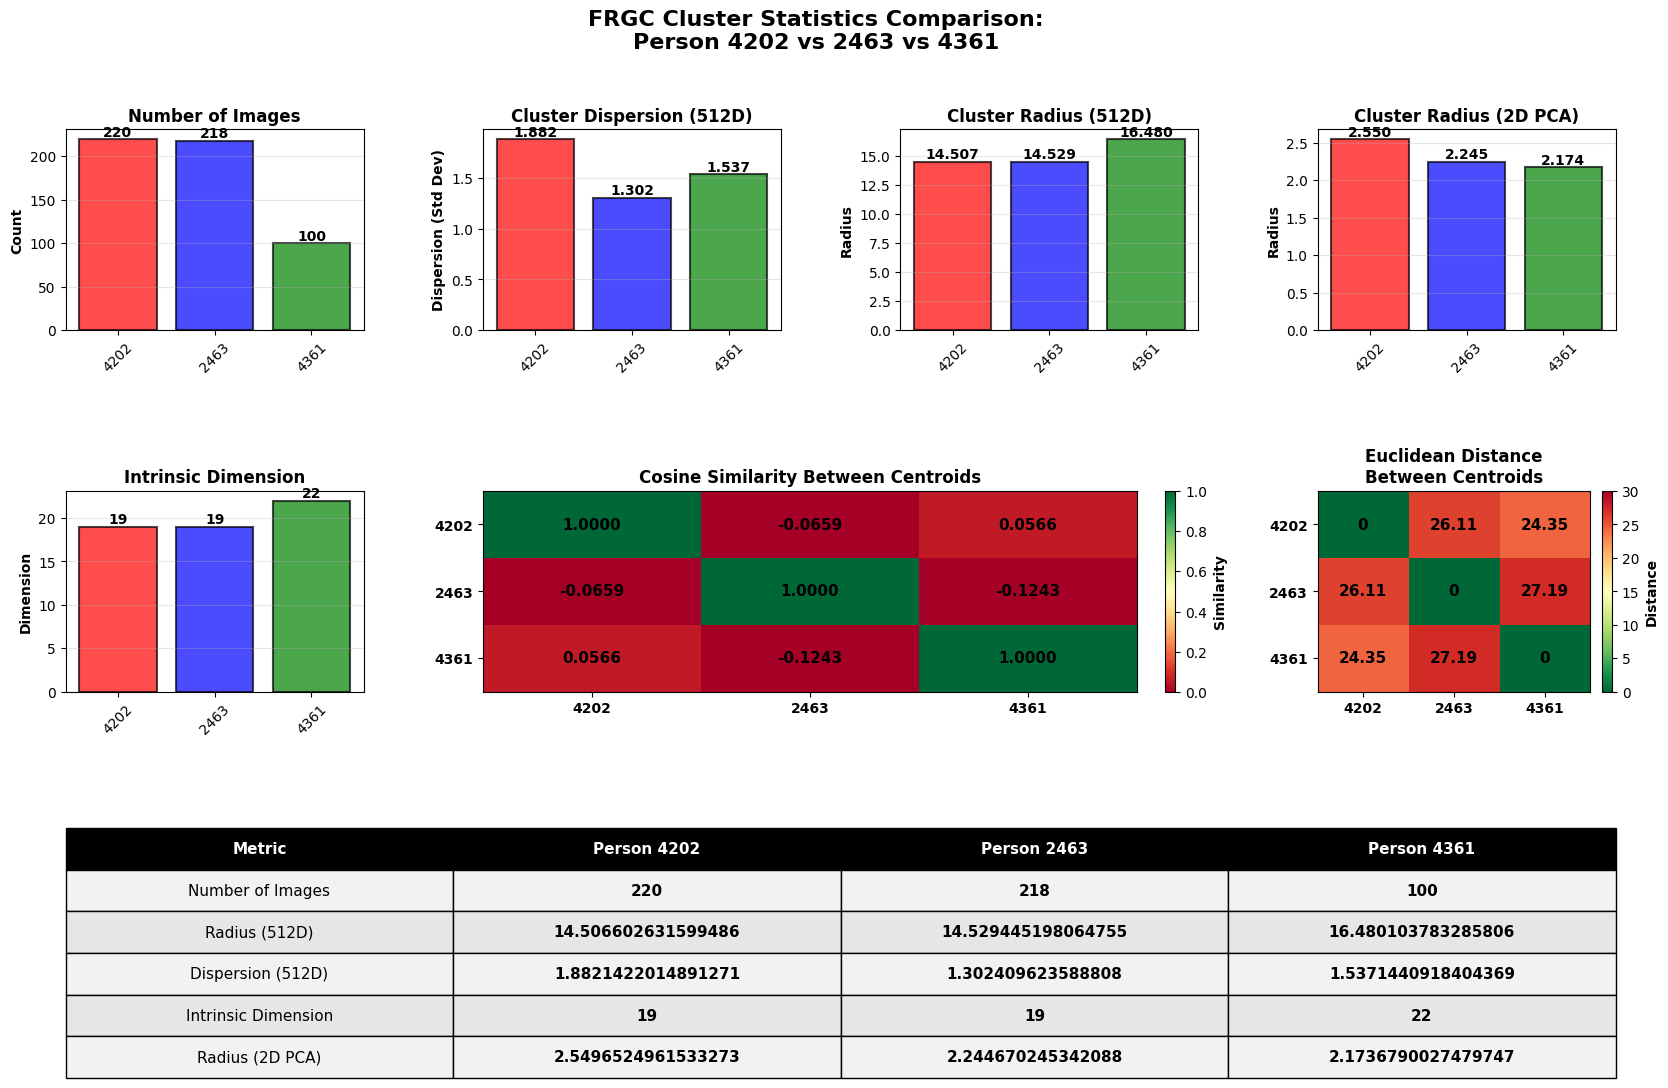

In [23]:
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 4, hspace=0.8, wspace=0.4)

# Create discrete x-axis positions
x_pos = range(len(individuals))

#number of images
ax1 = fig.add_subplot(gs[0, 0])
bars1 = ax1.bar(x_pos, metrics['num_images'], color=colors_bar, alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Count', fontweight='bold')
ax1.set_title('Number of Images', fontweight='bold', fontsize=12)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(individuals, rotation=45)
for bar, val in zip(bars1, metrics['num_images']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height, f'{val}',ha='center', va='bottom', fontweight='bold', fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

#cluster dispersion 512D
ax2 = fig.add_subplot(gs[0, 1])
bars2 = ax2.bar(x_pos, metrics['dispersion_512d'], color=colors_bar, alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Dispersion (Std Dev)', fontweight='bold')
ax2.set_title('Cluster Dispersion (512D)', fontweight='bold', fontsize=12)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(individuals, rotation=45)
for bar, val in zip(bars2, metrics['dispersion_512d']):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'{val:.3f}',ha='center', va='bottom', fontweight='bold', fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

#cluster radius 512D
ax3 = fig.add_subplot(gs[0, 2])
bars3 = ax3.bar(x_pos, metrics['radius_512d'], color=colors_bar, alpha=0.7, edgecolor='black', linewidth=1.5)
ax3.set_ylabel('Radius', fontweight='bold')
ax3.set_title('Cluster Radius (512D)', fontweight='bold', fontsize=12)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(individuals, rotation=45)
for bar, val in zip(bars3, metrics['radius_512d']):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height, f'{val:.3f}',ha='center', va='bottom', fontweight='bold', fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')

#cluster radius 2D PCA
ax4 = fig.add_subplot(gs[0, 3])
bars4 = ax4.bar(x_pos, metrics['radius_2d'], color=colors_bar, alpha=0.7, edgecolor='black', linewidth=1.5)
ax4.set_ylabel('Radius', fontweight='bold')
ax4.set_title('Cluster Radius (2D PCA)', fontweight='bold', fontsize=12)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(individuals, rotation=45)
for bar, val in zip(bars4, metrics['radius_2d']):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height, f'{val:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
ax4.grid(True, alpha=0.3, axis='y')

#intrinsic dimension
ax5 = fig.add_subplot(gs[1, 0])
bars5 = ax5.bar(x_pos, metrics['intrinsic_dims'], color=colors_bar, alpha=0.7, edgecolor='black', linewidth=1.5)
ax5.set_ylabel('Dimension', fontweight='bold')
ax5.set_title('Intrinsic Dimension', fontweight='bold', fontsize=12)
ax5.set_xticks(x_pos)
ax5.set_xticklabels(individuals, rotation=45)
for bar, val in zip(bars5, metrics['intrinsic_dims']):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height, f'{val}',ha='center', va='bottom', fontweight='bold', fontsize=10)
ax5.grid(True, alpha=0.3, axis='y')

#cosine similarity
ax6 = fig.add_subplot(gs[1, 1:3])
im1 = ax6.imshow(cos_sim_matrix, cmap='RdYlGn', vmin=0, vmax=1, aspect='auto')
ax6.set_xticks(range(3))
ax6.set_yticks(range(3))
ax6.set_xticklabels(short_names, fontweight='bold')
ax6.set_yticklabels(short_names, fontweight='bold')
ax6.set_title('Cosine Similarity Between Centroids', fontweight='bold', fontsize=12)
for i in range(3):
    for j in range(3):
        text = ax6.text(j, i, f'{cos_sim_matrix[i, j]:.4f}',ha="center", va="center", color="black", fontsize=11, fontweight='bold')
cbar1 = plt.colorbar(im1, ax=ax6, fraction=0.046, pad=0.04)
cbar1.set_label('Similarity', fontweight='bold')

#euclidean distance heatmap
ax7 = fig.add_subplot(gs[1, 3])
im2 = ax7.imshow(eucl_dist_matrix, cmap='RdYlGn_r', vmin=0, vmax=30, aspect='auto')
ax7.set_xticks(range(3))
ax7.set_yticks(range(3))
ax7.set_xticklabels(short_names, fontweight='bold')
ax7.set_yticklabels(short_names, fontweight='bold')
ax7.set_title('Euclidean Distance\nBetween Centroids', fontweight='bold', fontsize=12)
for i in range(3):
    for j in range(3):
        val = eucl_dist_matrix[i, j]
        text = ax7.text(j, i, f'{val:.2f}' if val > 0 else '0',ha="center", va="center", color="black", fontsize=11, fontweight='bold')
cbar2 = plt.colorbar(im2, ax=ax7, fraction=0.046, pad=0.04)
cbar2.set_label('Distance', fontweight='bold')

#comparative metrics table
ax8 = fig.add_subplot(gs[2, :])
ax8.axis('tight')
ax8.axis('off')
table_data = [
    ['Metric', f'Person {individuals[0]}', f'Person {individuals[1]}', f'Person {individuals[2]}'],
    ['Number of Images', metrics['num_images'][0], metrics['num_images'][1], metrics['num_images'][2]],
    ['Radius (512D)', metrics['radius_512d'][0], metrics['radius_512d'][1], metrics['radius_512d'][2]],
    ['Dispersion (512D)', metrics['dispersion_512d'][0], metrics['dispersion_512d'][1], metrics['dispersion_512d'][2]],
    ['Intrinsic Dimension', metrics['intrinsic_dims'][0], metrics['intrinsic_dims'][1], metrics['intrinsic_dims'][2]],
    ['Radius (2D PCA)', metrics['radius_2d'][0], metrics['radius_2d'][1], metrics['radius_2d'][2]],
]
table = ax8.table(cellText=table_data, cellLoc='center', loc='center',colWidths=[0.25, 0.25, 0.25, 0.25])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

#header row
for i in range(4):
    cell = table[(0, i)]
    cell.set_facecolor('black')
    cell.set_text_props(weight='bold', color='white')
#data rows with alternating colors
for i in range(1, 6):
    for j in range(4):
        cell = table[(i, j)]
        if i % 2 == 0:
            cell.set_facecolor('#E7E6E6')
        else:
            cell.set_facecolor('#F2F2F2')
        if j > 0:  # Data columns
            cell.set_text_props(weight='bold')

plt.suptitle(f'FRGC Cluster Statistics Comparison:\nPerson {individuals[0]} vs {individuals[1]} vs {individuals[2]}',fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()

plt.show()

## 7. Cosine similarity between clusters

In [24]:
labels_arr = np.array(valid_person_ids)
unique_ids = np.unique(labels_arr)
similarities = []
identity_pairs = []

for i in range(len(unique_ids) - 1):
    lbl1 = unique_ids[i]
    lbl2 = unique_ids[i+1]
    c1 = cluster_stats[lbl1]['centroid']
    c2 = cluster_stats[lbl2]['centroid']
    sim = cosine_similarity(c1.reshape(1,-1), c2.reshape(1,-1))[0,0]
    similarities.append(sim)
    identity_pairs.append(f"{str(lbl1)[:3]} vs {str(lbl2)[:3]}")
    print(f"Cosine similarity {lbl1} vs {lbl2}: {sim}")

Cosine similarity 2463 vs 4201: 0.09653127623442277
Cosine similarity 4201 vs 4202: -0.048344078385030353
Cosine similarity 4202 vs 4203: 0.06100253357088985
Cosine similarity 4203 vs 4213: -0.023854899531203105
Cosine similarity 4213 vs 4217: 0.09019998578153313
Cosine similarity 4217 vs 4221: 0.09876424034734382
Cosine similarity 4221 vs 4222: 0.09108343973416647
Cosine similarity 4222 vs 4225: 0.041311963652886835
Cosine similarity 4225 vs 4233: 0.010416110750392532
Cosine similarity 4233 vs 4239: -0.030455155583824563
Cosine similarity 4239 vs 4261: -0.09020609939592034
Cosine similarity 4261 vs 4265: -0.1105497331197857
Cosine similarity 4265 vs 4273: 0.05000395846777033
Cosine similarity 4273 vs 4279: -0.05662035371595127
Cosine similarity 4279 vs 4286: 0.03125785769264139
Cosine similarity 4286 vs 4288: -0.09688767450210772
Cosine similarity 4288 vs 4297: 0.018136868680616806
Cosine similarity 4297 vs 4300: 0.12264542770209635
Cosine similarity 4300 vs 4301: 0.05888158745535155


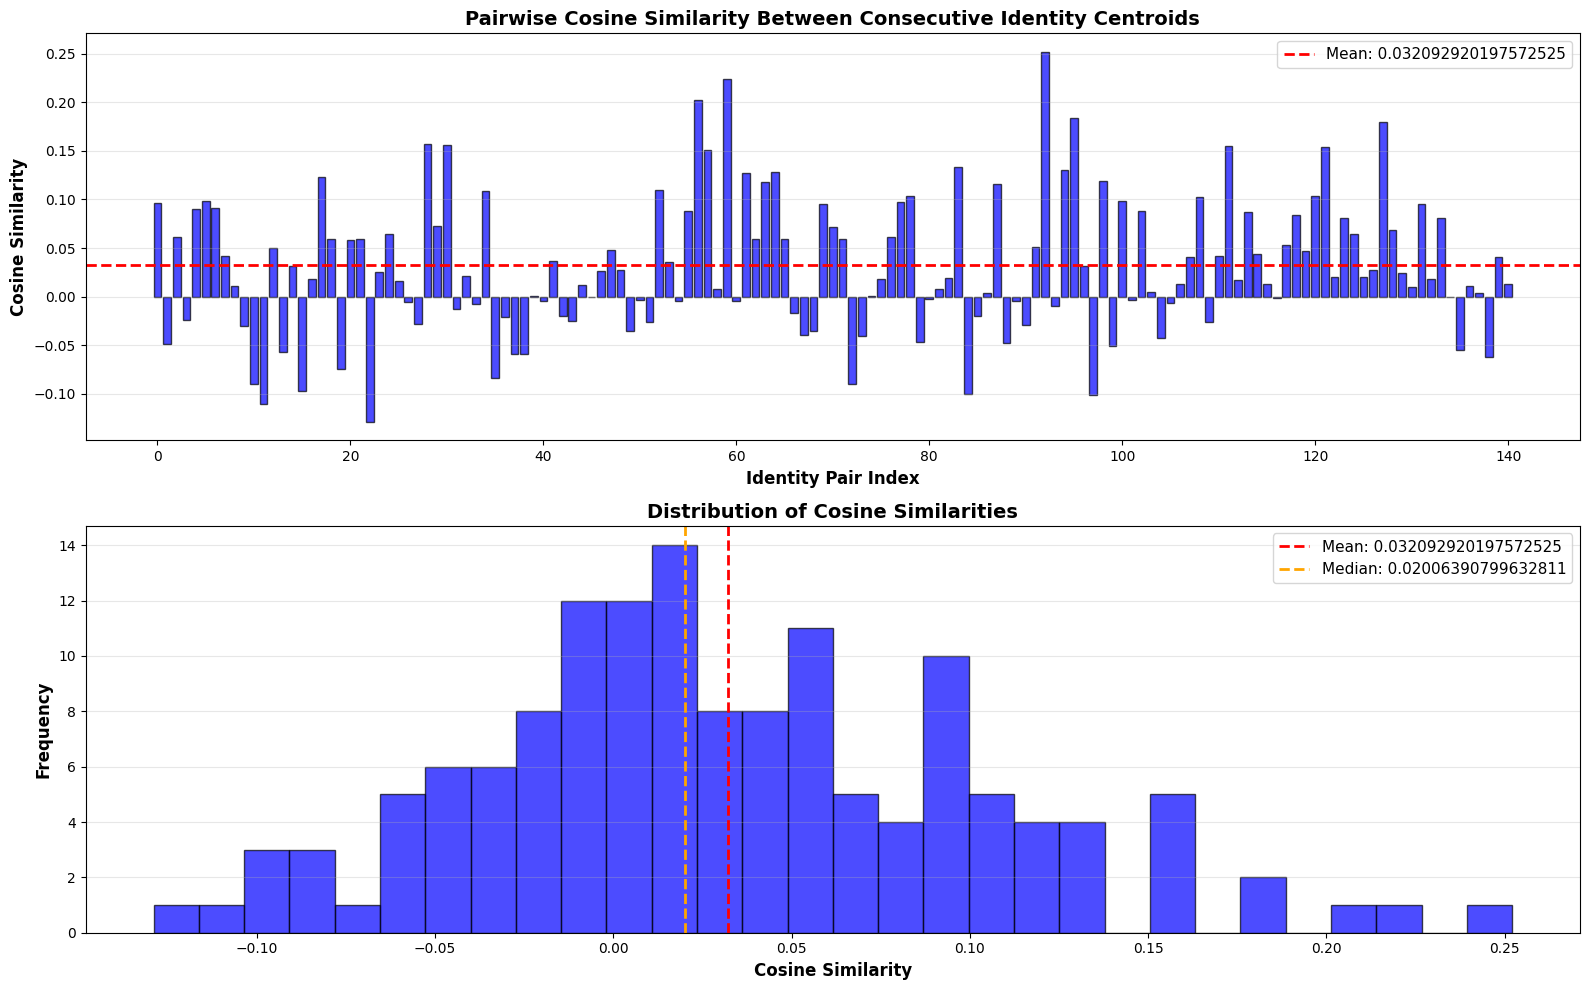

COSINE SIMILARITY STATISTICS (Consecutive Pairs):
Mean similarity: 0.032092920197572525
Median similarity: 0.02006390799632811
Std deviation: 0.07068562724612519
Min similarity: -0.1289115377858041
Max similarity: 0.25207790856847584


In [25]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

#cosine similarities
axes[0].bar(range(len(similarities)), similarities, color='blue', alpha=0.7, edgecolor='black')
axes[0].axhline(y=np.mean(similarities), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(similarities)}')
axes[0].set_xlabel('Identity Pair Index', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Cosine Similarity', fontsize=12, fontweight='bold')
axes[0].set_title('Pairwise Cosine Similarity Between Consecutive Identity Centroids', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')
#distribution histogram
axes[1].hist(similarities, bins=30, color='blue', alpha=0.7, edgecolor='black')
axes[1].axvline(x=np.mean(similarities), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(similarities)}')
axes[1].axvline(x=np.median(similarities), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(similarities)}')
axes[1].set_xlabel('Cosine Similarity', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_title('Distribution of Cosine Similarities', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

#stats
print("="*70)
print("COSINE SIMILARITY STATISTICS (Consecutive Pairs):")
print("="*70)
print(f"Mean similarity: {np.mean(similarities)}")
print(f"Median similarity: {np.median(similarities)}")
print(f"Std deviation: {np.std(similarities)}")
print(f"Min similarity: {np.min(similarities)}")
print(f"Max similarity: {np.max(similarities)}")

## 8. Analyze cluster stats

In [26]:
#cluster data to DataFrame
cluster_stats_df = pd.DataFrame.from_dict(cluster_stats, orient='index')
print(cluster_stats_df.head())

                                               centroid     radius  \
2463  [1.360797599403669, -0.5536179055706422, 0.819...  14.529445   
4201  [0.4796536409117648, -0.558056888622794, 0.651...  15.327252   
4202  [-1.2600162423636356, 0.5038748132050004, 0.38...  14.506603   
4203  [1.2284519615346536, 0.3379289293267328, -2.47...  13.653715   
4213  [0.216522155, 0.34780762640384616, -0.30062357...  15.257388   

      dispersion  num_images  
2463    1.302410         218  
4201    1.555068         136  
4202    1.882142         220  
4203    1.691873         202  
4213    1.443619         104  


In [27]:
intrinsic_dim_df = pd.DataFrame.from_dict(intrinsic_dim, orient='index', columns=['intrinsic_dimension'])
merged_df = intrinsic_dim_df.merge(cluster_stats_df, left_index=True, right_index=True)
print("Merged DataFrame created successfully")
print(merged_df.head())

Merged DataFrame created successfully
      intrinsic_dimension                                           centroid  \
2463                   19  [1.360797599403669, -0.5536179055706422, 0.819...   
4201                   22  [0.4796536409117648, -0.558056888622794, 0.651...   
4202                   19  [-1.2600162423636356, 0.5038748132050004, 0.38...   
4203                   18  [1.2284519615346536, 0.3379289293267328, -2.47...   
4213                   23  [0.216522155, 0.34780762640384616, -0.30062357...   

         radius  dispersion  num_images  
2463  14.529445    1.302410         218  
4201  15.327252    1.555068         136  
4202  14.506603    1.882142         220  
4203  13.653715    1.691873         202  
4213  15.257388    1.443619         104  


In [28]:
print("Summary Statistics for Merged DataFrame:")
print(merged_df[['intrinsic_dimension', 'radius', 'dispersion', 'num_images']].describe())

Summary Statistics for Merged DataFrame:
       intrinsic_dimension      radius  dispersion  num_images
count           142.000000  142.000000  142.000000  142.000000
mean             19.866197   15.177572    1.527068  147.197183
std               1.830509    1.951498    0.255775   33.289668
min              15.000000   11.641409    0.987152  100.000000
25%              19.000000   14.021579    1.351327  118.000000
50%              20.000000   14.810044    1.486415  141.000000
75%              21.000000   15.940097    1.687278  176.000000
max              25.000000   26.103618    2.351281  220.000000


In [29]:
print("\nIdentities with most consistent face embeddings (smallest radius):")
print(cluster_stats_df.sort_values(by='radius', ascending=True).head())

print("\nIdentities with least consistent face embeddings (largest radius):")
print(cluster_stats_df.sort_values(by='radius', ascending=False).head())

print("\nIdentities with least dispersed embeddings (smallest dispersion):")
print(cluster_stats_df.sort_values(by='dispersion', ascending=True).head())

print("\nIdentities with most dispersed embeddings (largest dispersion):")
print(cluster_stats_df.sort_values(by='dispersion', ascending=False).head())

print("\nIndividuals with the most images:")
print(cluster_stats_df.sort_values(by='num_images', ascending=False).head())


Identities with most consistent face embeddings (smallest radius):
                                               centroid     radius  \
4714  [-2.16232505614035, -0.3585785361824561, 0.719...  11.641409   
4429  [0.2495304585978261, 0.7580559509184783, -2.24...  11.844385   
4482  [0.08494454441813183, 0.022569321277472517, 0....  12.057331   
4631  [-0.06806534599901959, -0.4052004449509802, -0...  12.245073   
4615  [-0.02110096249462963, 0.399055880538889, 0.76...  12.285903   

      dispersion  num_images  
4714    1.091932         114  
4429    1.204072         184  
4482    1.143830         182  
4631    1.535453         102  
4615    1.430699         108  

Identities with least consistent face embeddings (largest radius):
                                               centroid     radius  \
4537  [-0.5821245963271604, 0.5064466696876545, 0.19...  26.103618   
4261  [1.5140047537931032, -0.734767350327586, -0.48...  22.372563   
4449  [-0.7233191171233769, -0.2077587000779221

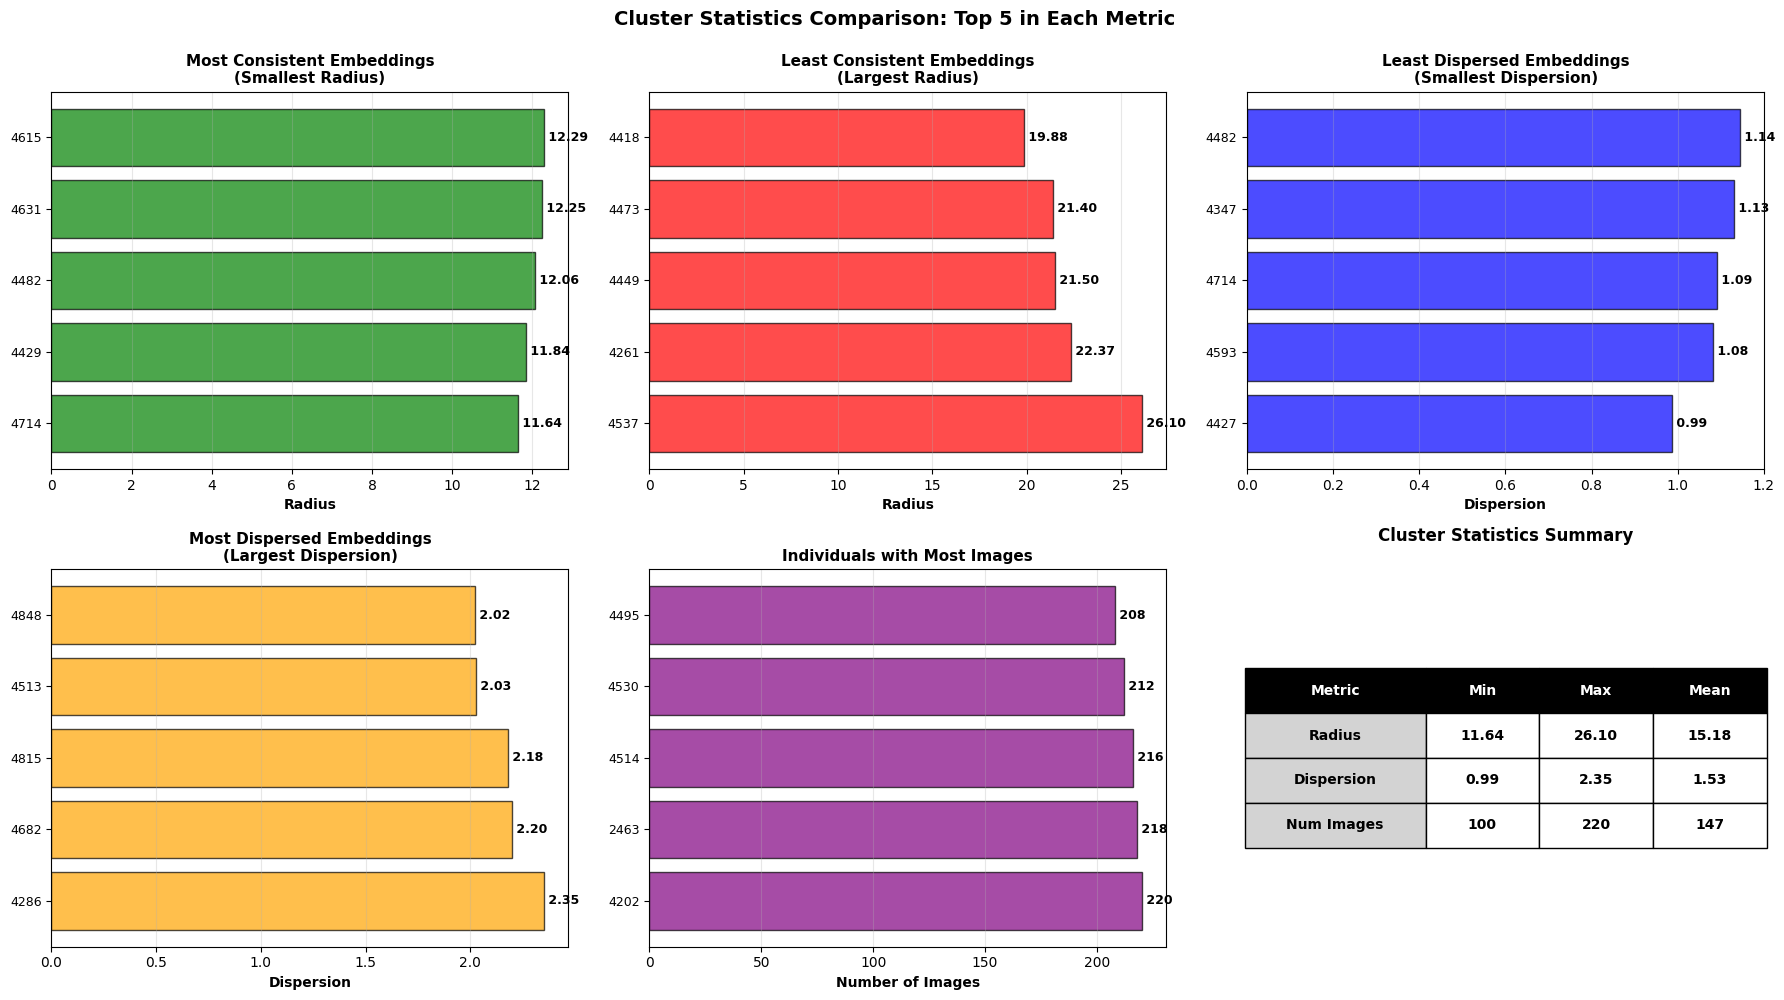

In [30]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

#smallest radius (most consistent)
smallest_radius = cluster_stats_df.sort_values(by='radius', ascending=True).head()
axes[0, 0].barh(range(len(smallest_radius)), smallest_radius['radius'], color='green', alpha=0.7, edgecolor='black')
axes[0, 0].set_yticks(range(len(smallest_radius)))
axes[0, 0].set_yticklabels(smallest_radius.index, fontsize=9)
axes[0, 0].set_xlabel('Radius', fontweight='bold')
axes[0, 0].set_title('Most Consistent Embeddings\n(Smallest Radius)', fontweight='bold', fontsize=11)
axes[0, 0].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(smallest_radius['radius']):
    axes[0, 0].text(val, i, f' {val:.2f}', va='center', fontweight='bold', fontsize=9)

#largest radius (least consistent)
largest_radius = cluster_stats_df.sort_values(by='radius', ascending=False).head()
axes[0, 1].barh(range(len(largest_radius)), largest_radius['radius'], color='red', alpha=0.7, edgecolor='black')
axes[0, 1].set_yticks(range(len(largest_radius)))
axes[0, 1].set_yticklabels(largest_radius.index, fontsize=9)
axes[0, 1].set_xlabel('Radius', fontweight='bold')
axes[0, 1].set_title('Least Consistent Embeddings\n(Largest Radius)', fontweight='bold', fontsize=11)
axes[0, 1].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(largest_radius['radius']):
    axes[0, 1].text(val, i, f' {val:.2f}', va='center', fontweight='bold', fontsize=9)

#smallest dispersion
smallest_dispersion = cluster_stats_df.sort_values(by='dispersion', ascending=True).head()
axes[0, 2].barh(range(len(smallest_dispersion)), smallest_dispersion['dispersion'], color='blue', alpha=0.7, edgecolor='black')
axes[0, 2].set_yticks(range(len(smallest_dispersion)))
axes[0, 2].set_yticklabels(smallest_dispersion.index, fontsize=9)
axes[0, 2].set_xlabel('Dispersion', fontweight='bold')
axes[0, 2].set_title('Least Dispersed Embeddings\n(Smallest Dispersion)', fontweight='bold', fontsize=11)
axes[0, 2].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(smallest_dispersion['dispersion']):
    axes[0, 2].text(val, i, f' {val:.2f}', va='center', fontweight='bold', fontsize=9)

#largest dispersion
largest_dispersion = cluster_stats_df.sort_values(by='dispersion', ascending=False).head()
axes[1, 0].barh(range(len(largest_dispersion)), largest_dispersion['dispersion'], color='orange', alpha=0.7, edgecolor='black')
axes[1, 0].set_yticks(range(len(largest_dispersion)))
axes[1, 0].set_yticklabels(largest_dispersion.index, fontsize=9)
axes[1, 0].set_xlabel('Dispersion', fontweight='bold')
axes[1, 0].set_title('Most Dispersed Embeddings\n(Largest Dispersion)', fontweight='bold', fontsize=11)
axes[1, 0].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(largest_dispersion['dispersion']):
    axes[1, 0].text(val, i, f' {val:.2f}', va='center', fontweight='bold', fontsize=9)

#images
most_images = cluster_stats_df.sort_values(by='num_images', ascending=False).head()
axes[1, 1].barh(range(len(most_images)), most_images['num_images'], color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].set_yticks(range(len(most_images)))
axes[1, 1].set_yticklabels(most_images.index, fontsize=9)
axes[1, 1].set_xlabel('Number of Images', fontweight='bold')
axes[1, 1].set_title('Individuals with Most Images', fontweight='bold', fontsize=11)
axes[1, 1].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(most_images['num_images']):
    axes[1, 1].text(val, i, f' {int(val)}', va='center', fontweight='bold', fontsize=9)

#statistics table
axes[1, 2].axis('tight')
axes[1, 2].axis('off')
summary_data = [
    ['Metric', 'Min', 'Max', 'Mean'],
    ['Radius', f"{cluster_stats_df['radius'].min():.2f}", f"{cluster_stats_df['radius'].max():.2f}", f"{cluster_stats_df['radius'].mean():.2f}"],
    ['Dispersion', f"{cluster_stats_df['dispersion'].min():.2f}", f"{cluster_stats_df['dispersion'].max():.2f}", f"{cluster_stats_df['dispersion'].mean():.2f}"],
    ['Num Images', f"{int(cluster_stats_df['num_images'].min())}", f"{int(cluster_stats_df['num_images'].max())}", f"{int(cluster_stats_df['num_images'].mean())}"]
]
table = axes[1, 2].table(cellText=summary_data, cellLoc='center', loc='center', colWidths=[0.35, 0.22, 0.22, 0.22])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)
for i in range(4): #header
    table[(0, i)].set_facecolor('black')
    table[(0, i)].set_text_props(weight='bold', color='white')
for i in range(1, 4): #rows
    table[(i, 0)].set_facecolor('#D3D3D3')
    table[(i, 0)].set_text_props(weight='bold')
    for j in range(1, 4):
        table[(i, j)].set_facecolor('white' if i % 2 == 0 else 'white')
        table[(i, j)].set_text_props(weight='bold')
axes[1, 2].set_title('Cluster Statistics Summary', fontweight='bold', fontsize=12, pad=20)

plt.suptitle('Cluster Statistics Comparison: Top 5 in Each Metric', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

- **Smallest Radius:** small average distance of ther embeddings from their centroids = face embeddings are tightly clustered, so they have higher consistency across different imgs of the same person
- **Largest Radius:** largest average distance from their centroids. Face embeddings are more spread out, so they have less consistency or greater variation in their imgs
- **Smallest Dispersion:** so small deviation of distances from their centroids, so the variation in embedding consistency are very low
- **Largest Dispersion:** largest deviation of distances, so they have more variability in the consistency of their embeddings. High dispersion = wider range of conditions in the imgs (pose, light, expression...)
- **Most Images:** lead to larger radii or dispersion due to greater diversity

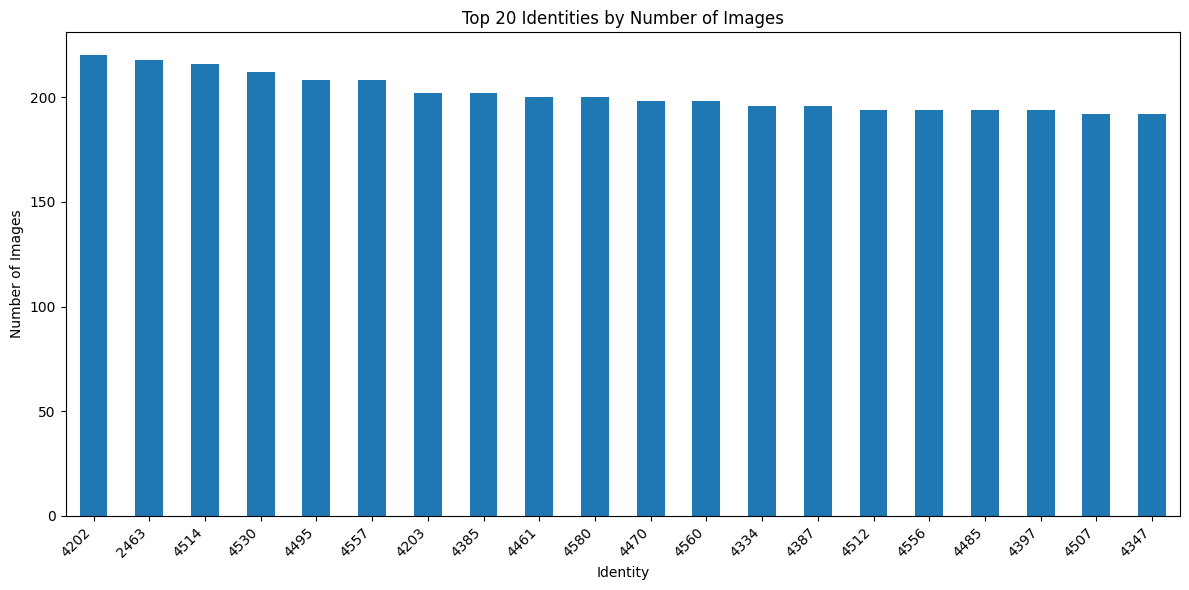

In [31]:
# number of imgs per identity bar plot
plt.figure(figsize=(12, 6))
top_n = 20  # Display top 20 identities
cluster_stats_df.sort_values(by='num_images', ascending=False).head(top_n)['num_images'].plot(kind='bar')
plt.title(f'Top {top_n} Identities by Number of Images')
plt.xlabel('Identity')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 9. Scatter Plot: Intrinsic Dimension vs. Cluster Dispersion

Higher intrinsic complexity in a person's image set often correlates with greater variability in the consistency of their face embeddings. The ArcFace model, while robust, shows signs of this increased challenge through higher dispersion values for identities with higher intrinsic dimensions.

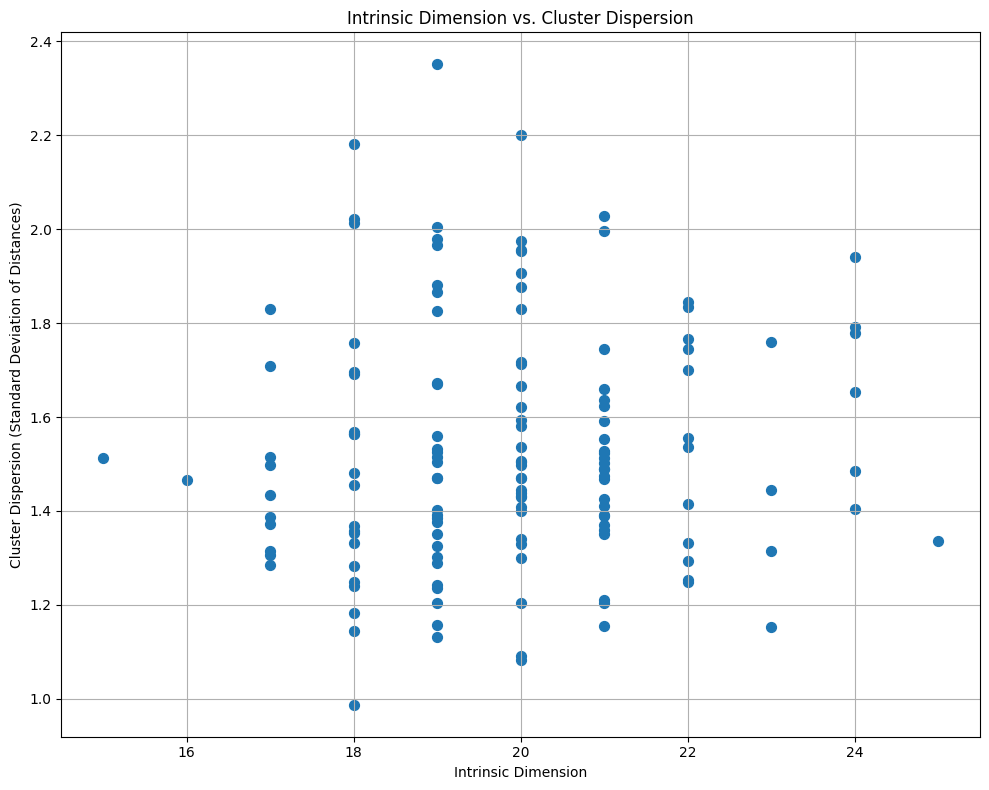

In [32]:
plt.figure(figsize=(10, 8))
plt.scatter(merged_df['intrinsic_dimension'], merged_df['dispersion'], s=50)
plt.title('Intrinsic Dimension vs. Cluster Dispersion')
plt.xlabel('Intrinsic Dimension')
plt.ylabel('Cluster Dispersion (Standard Deviation of Distances)')
plt.grid(True)
plt.tight_layout()
plt.show()

## 10. Scatter Plot: Radius vs Dispersion


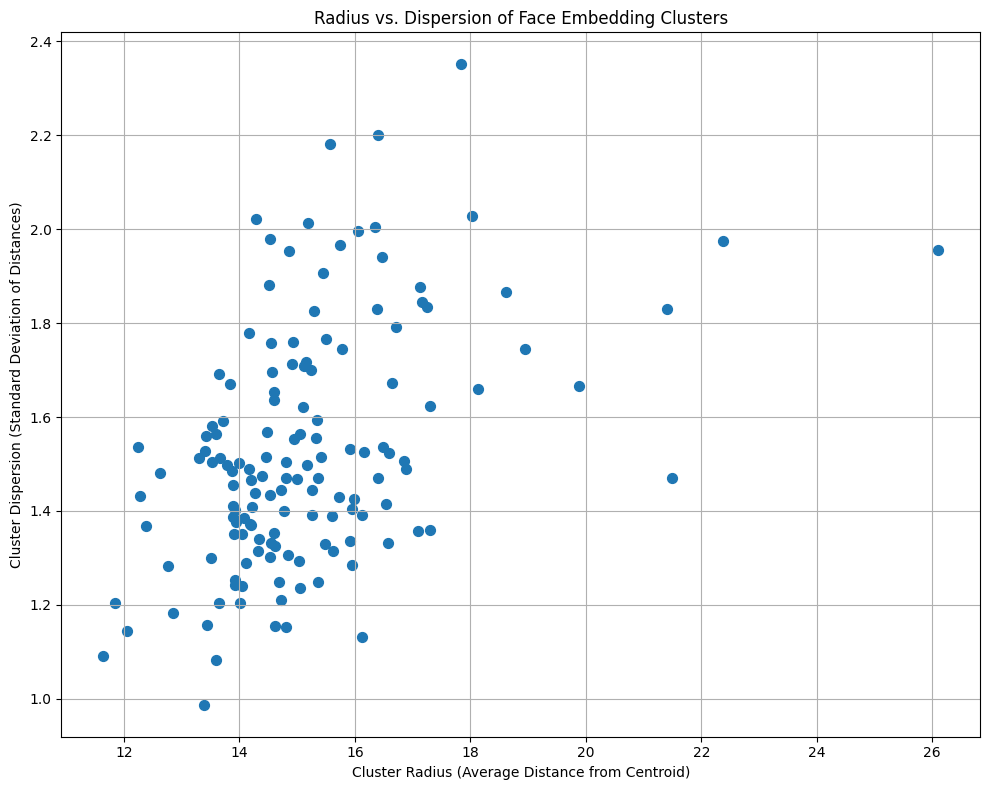

In [33]:
plt.figure(figsize=(10, 8))
plt.scatter(cluster_stats_df['radius'], cluster_stats_df['dispersion'], s=50)
plt.title('Radius vs. Dispersion of Face Embedding Clusters')
plt.xlabel('Cluster Radius (Average Distance from Centroid)')
plt.ylabel('Cluster Dispersion (Standard Deviation of Distances)')
plt.grid(True)
plt.tight_layout()
plt.show()

## 11. Intrinsic Dimension of Clusters


In [34]:
intrinsic_dim_df = pd.DataFrame.from_dict(intrinsic_dim, orient='index', columns=['intrinsic_dimension'])
print("Intrinsic Dimensionality DataFrame Head:")
print(intrinsic_dim_df.head())

Intrinsic Dimensionality DataFrame Head:
      intrinsic_dimension
2463                   19
4201                   22
4202                   19
4203                   18
4213                   23


In [35]:
print("\nDescriptive Statistics for Intrinsic Dimensionality:")
print(intrinsic_dim_df['intrinsic_dimension'].describe())

print("\nIdentities with the 10 highest intrinsic dimensions:")
print(intrinsic_dim_df.sort_values(by='intrinsic_dimension', ascending=False).head(10))

print("\nIdentities with the 10 lowest intrinsic dimensions:")
print(intrinsic_dim_df.sort_values(by='intrinsic_dimension', ascending=True).head(10))


Descriptive Statistics for Intrinsic Dimensionality:
count    142.000000
mean      19.866197
std        1.830509
min       15.000000
25%       19.000000
50%       20.000000
75%       21.000000
max       25.000000
Name: intrinsic_dimension, dtype: float64

Identities with the 10 highest intrinsic dimensions:
      intrinsic_dimension
4397                   25
4511                   24
4839                   24
4312                   24
4476                   24
4327                   24
4708                   24
4581                   23
4519                   23
4217                   23

Identities with the 10 lowest intrinsic dimensions:
      intrinsic_dimension
4514                   15
4684                   16
4580                   17
4485                   17
4773                   17
4512                   17
4388                   17
4670                   17
4379                   17
4334                   17



### Identities with High Intrinsic Dimensionality
exhibit a greater complexity or variability. This means that more principal components are needed to explain the variance within their respective clusters. This could be due to a wider range of poses, expressions, lighting conditions, or even image quality variations for these individuals in the LFW dataset.

### Identities with Low Intrinsic Dimensionality
their image clusters are less complex or more consistent. Fewer principal components are sufficient to capture the variance within their embeddings. This might imply that the images for these individuals are more uniform in terms of visual characteristics, or perhaps their facial features are inherently less variable across different images presented to the model.

In [36]:
top_10_high_intrinsic_dim_identities = intrinsic_dim_df.nlargest(10, 'intrinsic_dimension')
top_10_data = merged_df.loc[top_10_high_intrinsic_dim_identities.index][['intrinsic_dimension', 'radius', 'dispersion', 'num_images']]
print("\nMetrics for Identities with the 10 Highest Intrinsic Dimensions:")
print(top_10_data)


Metrics for Identities with the 10 Highest Intrinsic Dimensions:
      intrinsic_dimension     radius  dispersion  num_images
4397                   25  15.920932    1.336428         194
4312                   24  13.865077    1.484593         106
4327                   24  16.704379    1.792733         172
4476                   24  15.957017    1.404293         108
4511                   24  14.606813    1.654196         110
4708                   24  14.175530    1.778004         102
4839                   24  16.476571    1.941352         102
4213                   23  15.257388    1.443619         104
4217                   23  15.619355    1.314320         150
4519                   23  14.932130    1.759926         114


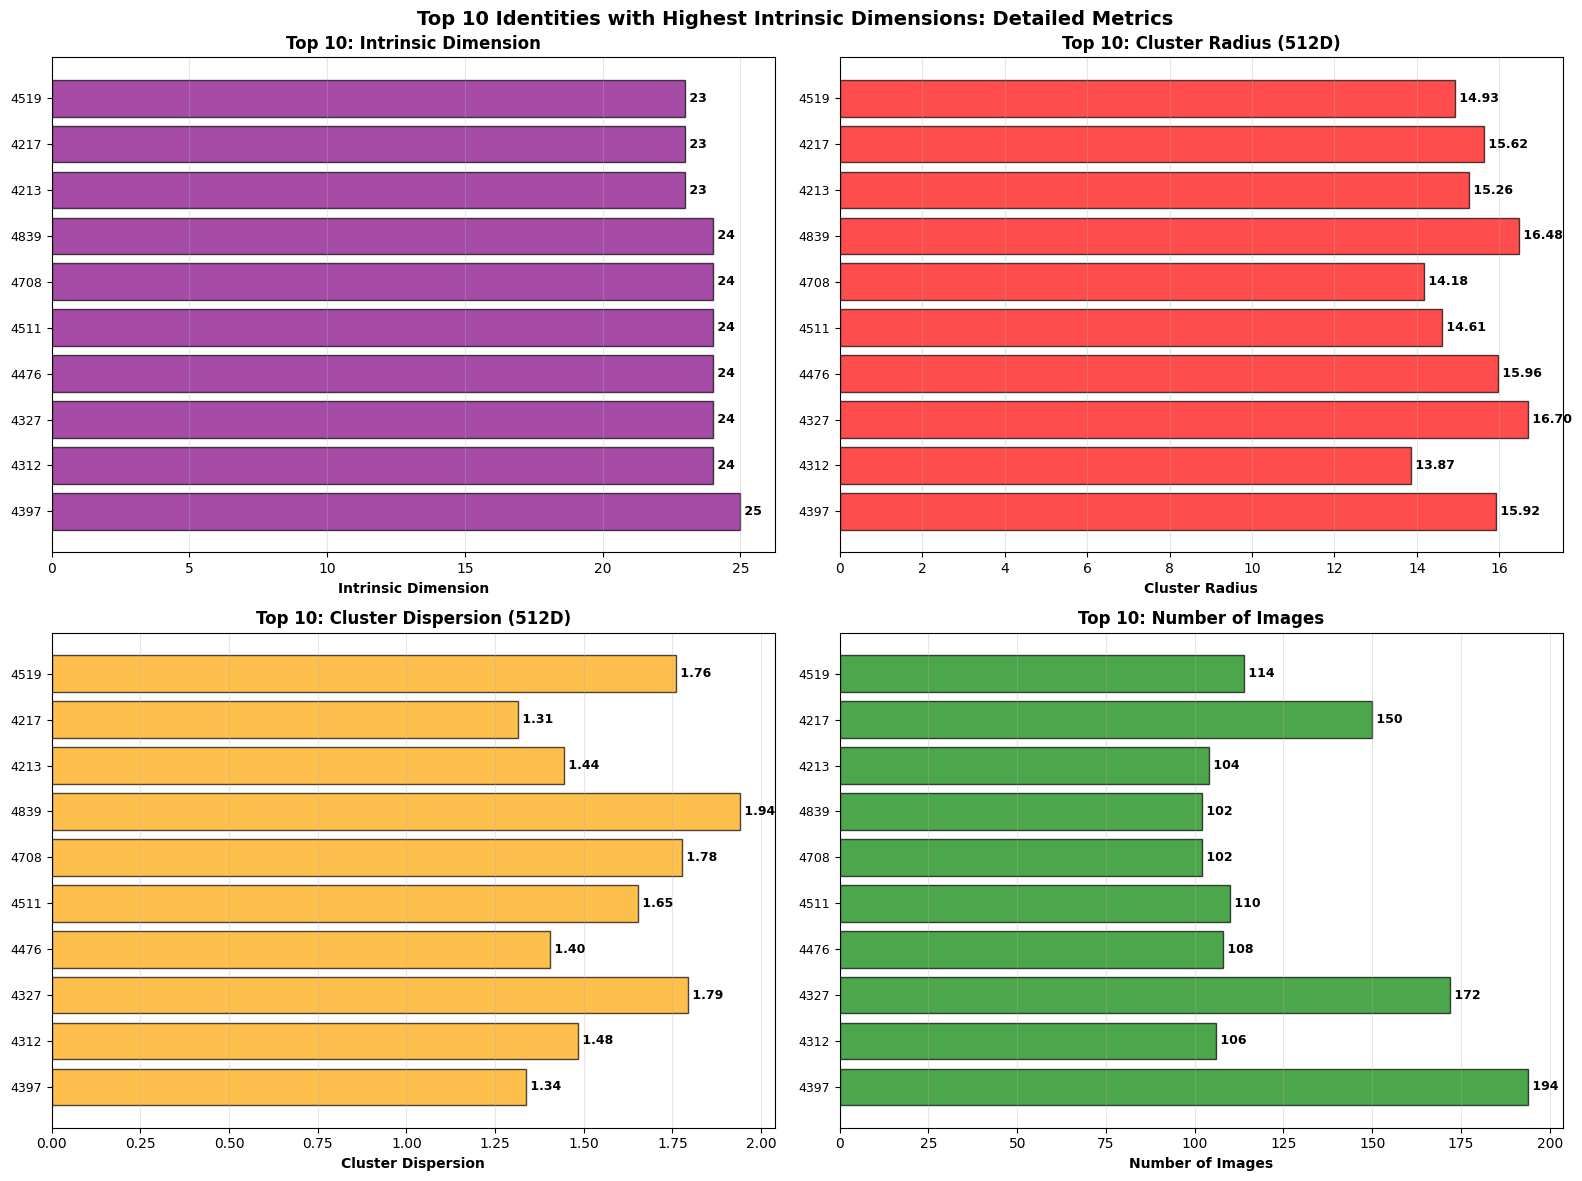

In [37]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

#intrinsic Dimension
axes[0, 0].barh(range(len(top_10_data)), top_10_data['intrinsic_dimension'], color='purple', alpha=0.7, edgecolor='black')
axes[0, 0].set_yticks(range(len(top_10_data)))
axes[0, 0].set_yticklabels(top_10_data.index, fontsize=9)
axes[0, 0].set_xlabel('Intrinsic Dimension', fontweight='bold')
axes[0, 0].set_title('Top 10: Intrinsic Dimension', fontweight='bold', fontsize=12)
axes[0, 0].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(top_10_data['intrinsic_dimension']):
    axes[0, 0].text(val, i, f' {int(val)}', va='center', fontweight='bold', fontsize=9)

#radius
axes[0, 1].barh(range(len(top_10_data)), top_10_data['radius'], color='red', alpha=0.7, edgecolor='black')
axes[0, 1].set_yticks(range(len(top_10_data)))
axes[0, 1].set_yticklabels(top_10_data.index, fontsize=9)
axes[0, 1].set_xlabel('Cluster Radius', fontweight='bold')
axes[0, 1].set_title('Top 10: Cluster Radius (512D)', fontweight='bold', fontsize=12)
axes[0, 1].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(top_10_data['radius']):
    axes[0, 1].text(val, i, f' {val:.2f}', va='center', fontweight='bold', fontsize=9)

#dispersion
axes[1, 0].barh(range(len(top_10_data)), top_10_data['dispersion'], color='orange', alpha=0.7, edgecolor='black')
axes[1, 0].set_yticks(range(len(top_10_data)))
axes[1, 0].set_yticklabels(top_10_data.index, fontsize=9)
axes[1, 0].set_xlabel('Cluster Dispersion', fontweight='bold')
axes[1, 0].set_title('Top 10: Cluster Dispersion (512D)', fontweight='bold', fontsize=12)
axes[1, 0].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(top_10_data['dispersion']):
    axes[1, 0].text(val, i, f' {val:.2f}', va='center', fontweight='bold', fontsize=9)

#number of Images
axes[1, 1].barh(range(len(top_10_data)), top_10_data['num_images'], color='green', alpha=0.7, edgecolor='black')
axes[1, 1].set_yticks(range(len(top_10_data)))
axes[1, 1].set_yticklabels(top_10_data.index, fontsize=9)
axes[1, 1].set_xlabel('Number of Images', fontweight='bold')
axes[1, 1].set_title('Top 10: Number of Images', fontweight='bold', fontsize=12)
axes[1, 1].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(top_10_data['num_images']):
    axes[1, 1].text(val, i, f' {int(val)}', va='center', fontweight='bold', fontsize=9)

plt.suptitle('Top 10 Identities with Highest Intrinsic Dimensions: Detailed Metrics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

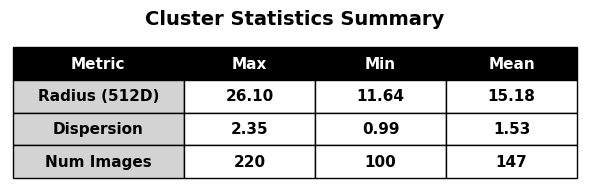

In [38]:
fig, ax = plt.subplots(figsize=(6, 2))
ax.axis('tight')
ax.axis('off')
summary_table_data = [
    ['Metric', 'Max', 'Min', 'Mean'],
    ['Radius (512D)', f"{merged_df['radius'].max():.2f}", f"{merged_df['radius'].min():.2f}", f"{merged_df['radius'].mean():.2f}"],
    ['Dispersion', f"{merged_df['dispersion'].max():.2f}", f"{merged_df['dispersion'].min():.2f}", f"{merged_df['dispersion'].mean():.2f}"],
    ['Num Images', f"{int(merged_df['num_images'].max())}", f"{int(merged_df['num_images'].min())}", f"{int(merged_df['num_images'].mean())}"]
]
table1 = ax.table(cellText=summary_table_data, cellLoc='center', loc='center', colWidths=[0.3, 0.23, 0.23, 0.23])
table1.auto_set_font_size(False)
table1.set_fontsize(11)
table1.scale(1, 2.5)
for i in range(4):
    table1[(0, i)].set_facecolor('black')
    table1[(0, i)].set_text_props(weight='bold', color='white')
for i in range(1, 4):
    table1[(i, 0)].set_facecolor('#D3D3D3')
    table1[(i, 0)].set_text_props(weight='bold')
    for j in range(1, 4):
        table1[(i, j)].set_facecolor('white')
        table1[(i, j)].set_text_props(weight='bold')
plt.title('Cluster Statistics Summary', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

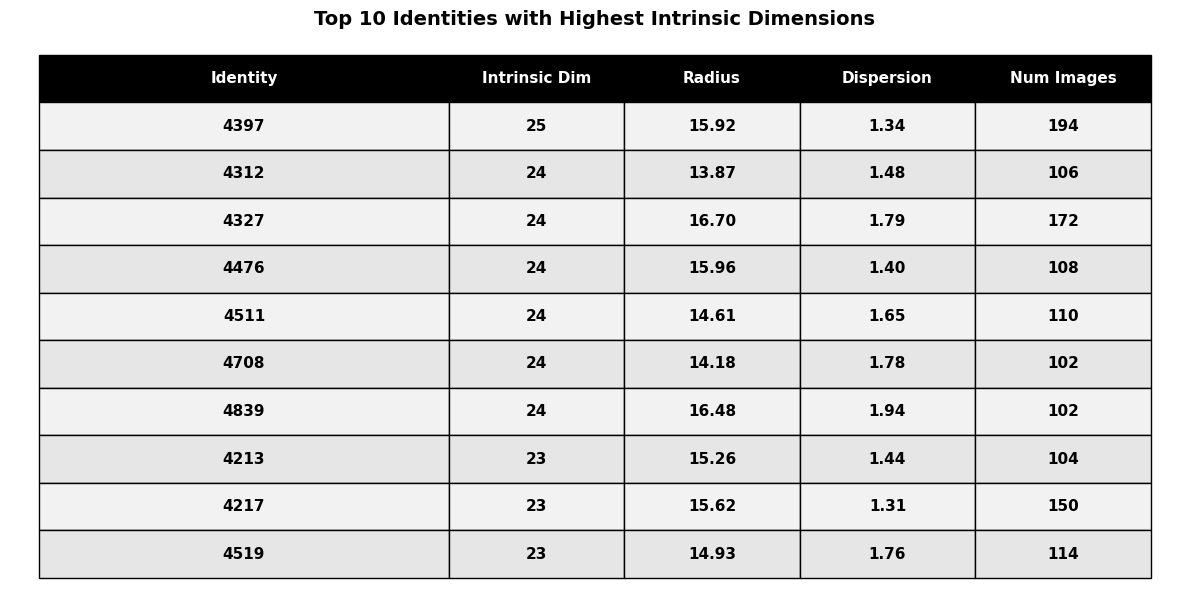

In [39]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('tight')
ax.axis('off')
table_data = [['Identity', 'Intrinsic Dim', 'Radius', 'Dispersion', 'Num Images']]
for identity, row in top_10_data.iterrows():
    table_data.append([
        identity,
        f"{int(row['intrinsic_dimension'])}",
        f"{row['radius']:.2f}",
        f"{row['dispersion']:.2f}",
        f"{int(row['num_images'])}"
    ])
table = ax.table(cellText=table_data, cellLoc='center', loc='center', colWidths=[0.35, 0.15, 0.15, 0.15, 0.15])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

for i in range(5):
    table[(0, i)].set_facecolor('black')
    table[(0, i)].set_text_props(weight='bold', color='white')
for i in range(1, len(table_data)):
    for j in range(5):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#E7E6E6')
        else:
            table[(i, j)].set_facecolor('#F2F2F2')
        table[(i, j)].set_text_props(weight='bold')
plt.title('Top 10 Identities with Highest Intrinsic Dimensions', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## 12. Scatter Plot: Radius and Number of Images


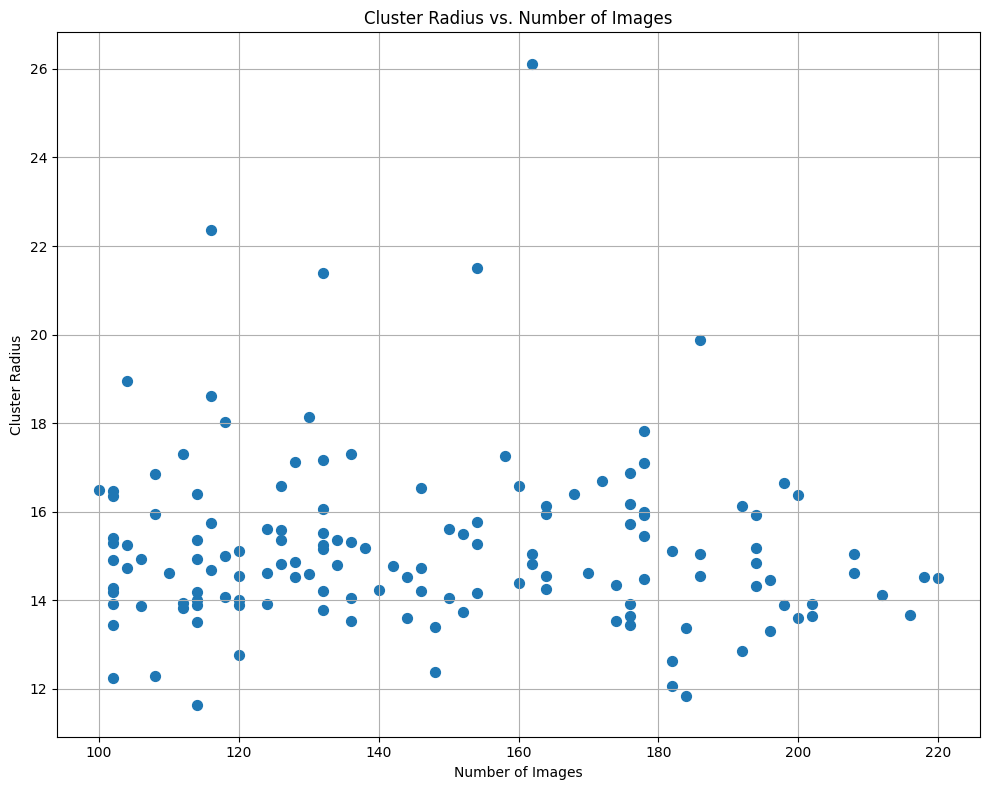

In [40]:
plt.figure(figsize=(10, 8))
plt.scatter(merged_df['num_images'], merged_df['radius'], s=50)
plt.title('Cluster Radius vs. Number of Images')
plt.xlabel('Number of Images')
plt.ylabel('Cluster Radius')
plt.grid(True)
plt.tight_layout()
plt.show()

No strong linear correlation between them


Even with few images some identites have very consistent embeddings, while others can be quite incosistent

